In [1]:
#prep

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image
pic_size = 48

# input path for the images
base_path = 'images/'

from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 1

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

total_data = datagen_train.flow_from_directory(base_path + "train/train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Using TensorFlow backend.


Found 87000 images belonging to 29 classes.


In [2]:
import numpy as np
d = np.random.permutation(87000)
# out of 10700 datasets I will be using 80:20 (10000 datasets) for training:validation && 700 for testing
x_train = np.empty((10000, 48, 48, 1), dtype=np.float32)
y_train = np.empty((10000, 29), dtype=np.float32)
x_test = np.empty((700, 48, 48, 1), dtype=np.float32)
y_test = np.empty((700, 29), dtype=np.float32)
for i in range(0,10000):
    x_train[i] = total_data[d[i]][0][0]
    y_train[i] = total_data[d[i]][1][0]
for i in range(10000,10700):
    x_test[i-10000] = total_data[d[i]][0][0] 
    y_test[i-10000] = total_data[d[i]][1][0] 
# Using data augmentation
def augment_data(i, weak_th = None, strong_th = None): 
    img = x_test[i]
    # conversion of image to grayscale 
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
       
    # Noise reduction step 
    img = cv2.GaussianBlur(img, (5, 5), 1.4) 
       
    # Calculating the gradients 
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3) 
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3) 
      
    # Conversion of Cartesian coordinates to polar  
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True) 
       
    # setting the minimum and maximum thresholds  
    # for double thresholding 
    mag_max = np.max(mag) 
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
      
    # getting the dimensions of the input image   
    height, width = img.shape 
       
    # Looping through every pixel of the grayscale  
    # image 
    for i_x in range(width): 
        for i_y in range(height): 
               
            grad_ang = ang[i_y, i_x] 
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang) 
               
            # selecting the neighbours of the target pixel 
            # according to the gradient direction 
            # In the x axis direction 
            if grad_ang<= 22.5: 
                neighb_1_x, neighb_1_y = i_x-1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y 
              
            # top right (diagnol-1) direction 
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45): 
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction 
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90): 
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagnol-2) direction 
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135): 
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle 
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180): 
                neighb_1_x, neighb_1_y = i_x-1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y 
               
            # Non-maximum suppression step 
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0: 
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]: 
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0: 
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]: 
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img) 
    strong_ids = np.zeros_like(img)               
    ids = np.zeros_like(img) 
       
    # double thresholding step 
    for i_x in range(width): 
        for i_y in range(height): 
              
            grad_mag = mag[i_y, i_x] 
              
            if grad_mag<weak_th: 
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th: 
                ids[i_y, i_x]= 1
            else: 
                ids[i_y, i_x]= 2
    
    return mag
for i in range(0,10000):
    aa = randint(0,1)
    if (aa==1) :
        x_test[i] = augment_data(x_test[i])

In [3]:
# new_val = []
# for i in range (0,len(val)):
#     for j in range (0,100):
#         new_val.append((val[i][j][0],val[i][j][1]))

In [4]:
# len(new_val)

In [5]:
#defining the model

from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 29

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

W1226 10:55:41.267582 140340371121984 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:72: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1226 10:55:41.289651 140340371121984 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:515: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1226 10:55:41.293081 140340371121984 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4048: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1226 10:55:41.323543 140340371121984 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:172: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instea

In [6]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=100)

W1226 10:55:42.205439 140340371121984 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 85s 11ms/step - loss: 3.3581 - acc: 0.1049 - val_loss: 2.9104 - val_acc: 0.1695
Epoch 2/50
8000/8000 [==============================] - 84s 11ms/step - loss: 2.7485 - acc: 0.2159 - val_loss: 2.6342 - val_acc: 0.2235
Epoch 3/50
8000/8000 [==============================] - 83s 10ms/step - loss: 2.4193 - acc: 0.2895 - val_loss: 2.6417 - val_acc: 0.2225
Epoch 4/50
8000/8000 [==============================] - 90s 11ms/step - loss: 2.1528 - acc: 0.3646 - val_loss: 2.4210 - val_acc: 0.2755
Epoch 5/50
8000/8000 [==============================] - 84s 11ms/step - loss: 1.9543 - acc: 0.4221 - val_loss: 2.1179 - val_acc: 0.3630
Epoch 6/50
8000/8000 [==============================] - 82s 10ms/step - loss: 1.7605 - acc: 0.4729 - val_loss: 2.1031 - val_acc: 0.3750
Epoch 7/50
8000/8000 [==============================] - 81s 10ms/step - loss: 1.5892 - acc: 0.5255 - val_loss: 1.7268 - val_acc: 0.4790


In [9]:
def num(x):
    for i in range(0,29):
        if(x[i]==1):
            return i

s = model.predict_classes(x_test)
# print("Prediction is :: ")
# print(s[1])
# print("Actual is ::")
# print(num(y_test[1]))
errors = 0
for i in range(0,700):
    if(s[i]!=num(y_test[i])):
        errors += 1
print("Accuracy is ::")
print((700-errors)/700)

Accuracy is ::
0.9271428571428572


In [10]:
model_json = model.to_json()
with open("Image_model.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
model.save_weights('Image_model_weights.h5')
print('Weights saved')

Model Saved
Weights saved


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


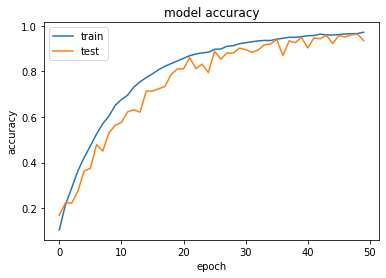

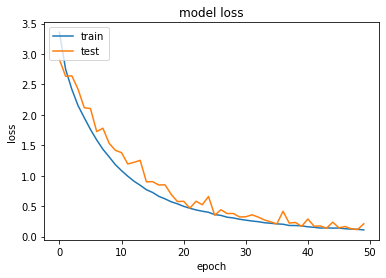

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
print(type(history))

<class 'keras.callbacks.History'>
